# IBM Applied Data Science Capstone 

### Helping investors find the perfect location to open a coffee shop in Toronto, Canada

In [1]:
# installing and importing all the necessary packages
import numpy as np 
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json 

# installing geocoder
! pip install geocoder
import geocoder 

# library to handle requests
import requests 
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
! pip install folium
import folium 

# install and import beautifulsoup
! pip install beautifulsoup4
from bs4 import BeautifulSoup

# install lxml
! pip install lxml
import lxml.html as lh

print('Libraries imported.')

     |████████████████████████████████| 98 kB 8.8 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 5.6 MB/s  eta 0:00:01
Libraries imported.


In [2]:
# Extracting the neighbourhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

result = requests.get(url)
data_html = BeautifulSoup(result.content)


soup = BeautifulSoup(str(data_html))

neigh = soup.find('table')

table_str = str(neigh.extract())

# saving the data into a pandas dataframe
df = pd.read_html(table_str,flavor='html5lib')[0]

df.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [3]:
# Cleaning the data frame

# filter out the rows where 'Borough' == 'Not assigned'
df1 = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)

# set a value for neighbourhood when neighbourhood == not assigned 
df1['Neighbourhood'] = np.where((df1['Neighbourhood'] == 'Not assigned') , df1['Borough'], df1['Neighbourhood'])
df = df1
df.head()

Postal Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [4]:
# Find the dimensions of the cleaned data frame
df.shape

(103, 3)

In [5]:
df.head()

Postal Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

#### Finding the geographical latitudes and longitudes for each neighbourhood

In [6]:
# We will now add the latitude and the longitude columns to the dataframe
df_latLon = df.reindex(df.columns.tolist() + ['Latitude', 'Longitude'], axis=1)
df = df_latLon
df.head()

Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

   Latitude  Longitude  
0       NaN        NaN  
1       NaN        NaN  
2       NaN        NaN  
3       NaN        NaN  
4       NaN        NaN

In [7]:
# Using geocoder we will get the latitudes and longitudes for each neighbourhood and populate them in the dataframe
import geocoder
postal_code = df['Postal Code']

# Using while Statement
latitude = []
longitude = []
n = 0

while n < len(postal_code):
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code[n]))
    lat_lng_coords = g.latlng
#     print('The geograpical coordinate of {} are {}, {}.'.format(postal_code[n], lat_lng_coords[0], lat_lng_coords[1]))
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    n = n + 1

df['Latitude'] = latitude
df['Longitude'] = longitude

df.head()

Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

   Latitude  Longitude  
0  43.75245  -79.32991  
1  43.73057  -79.31306  
2  43.65512  -79.36264  
3  43.72327  -79.45042  
4  43.66253  -79.39188

In [8]:
# Displaying the shape of the newly updated dataframe
df.shape

(103, 5)

In [9]:
# Finding out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

In [10]:
# creating a Toronto dataframe to use
df_toronto = df
df_toronto.head()

Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

   Latitude  Longitude  
0  43.75245  -79.32991  
1  43.73057  -79.31306  
2  43.65512  -79.36264  
3  43.72327  -79.45042  
4  43.66253  -79.39188

#### Exploring neibourhoods in Toronto

In [11]:
#Create list with the Boroughs (for later use)
boroughs = df_toronto['Borough'].unique().tolist()

In [12]:
#  use geocoder to obtain the latitudes and longitudes for the city of toronto
t = geocoder.arcgis('{}, Toronto, Ontario')
t_lat = t.latlng[0]
t_long = t.latlng[1]
print('The geograpical coordinates for the city of Toronto are {}, {}.'.format(t_lat, t_long))

The geograpical coordinates for the city of Toronto are 43.648690000000045, -79.38543999999996.


In [13]:
# Create a map of Toronto with using latitutes and longitute for the city
map_toronto = folium.Map(location=[t_lat, t_long], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format('Neighbourhood', 'Borough')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [14]:
# @hidden_cell
# Define foursquare credentials and version
CLIENT_ID = 'QMGRAV35HM4J0RRZL43O1UTUI245OPC23UKVZ0YEHFSTWJOI' # your Foursquare ID
CLIENT_SECRET = 'DN32WVDGN2ZK43H3FXXH22YFXPHMBLKR5F22RZCKKVMD1WWB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

#### Exploring venues using the foursquare api

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    LIMIT = 500 # limit of number of venues returned by Foursquare API
    radius = 1000 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
     
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# Getting venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

In [17]:
toronto_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0     Parkwoods                43.75245                -79.32991   
1     Parkwoods                43.75245                -79.32991   
2     Parkwoods                43.75245                -79.32991   
3     Parkwoods                43.75245                -79.32991   
4     Parkwoods                43.75245                -79.32991   

               Venue  Venue Latitude  Venue Longitude        Venue Category  
0    Allwyn's Bakery       43.759840       -79.324719  Caribbean Restaurant  
1    Brookbanks Park       43.751976       -79.332140                  Park  
2        Tim Hortons       43.760668       -79.326368                  Café  
3  Bruno's valu-mart       43.746143       -79.324630         Grocery Store  
4                A&W       43.760643       -79.326865  Fast Food Restaurant

#### Finding all the the unique venues

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 331 uniques categories.


In [19]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Caribbean Restaurant' 'Park' 'Café' 'Grocery Store'
 'Fast Food Restaurant' 'Pharmacy' 'Supermarket' 'Fish & Chips Shop'
 'Pizza Place' 'Food & Drink Shop' 'Hotel' 'Intersection' 'Bus Stop'
 'Cosmetics Shop' 'Skating Rink' 'Shop & Service' 'Train Station'
 'Discount Store' 'Tennis Court' 'Laundry Service' 'ATM'
 'Chinese Restaurant' 'Middle Eastern Restaurant' 'Thai Restaurant'
 'Hockey Arena' 'Portuguese Restaurant' 'Coffee Shop' 'French Restaurant'
 'Mediterranean Restaurant' 'Spa' 'Bakery' 'Breakfast Spot'
 'Italian Restaurant' 'Restaurant' 'Pub' 'Farmers Market'
 'Greek Restaurant' 'Liquor Store' 'Historic Site' 'Yoga Studio'
 'Distribution Center' 'Chocolate Shop' 'Event Space' 'Pool'
 'Tech Startup' 'Performing Arts Venue' 'Dessert Shop' 'Diner'
 'German Restaurant' 'Theater' 'Gym / Fitness Center'
 'Furniture / Home Store' 'Food Truck' 'Gastropub' 'Animal Shelter'
 'Shoe Store' 'Asian Restaurant' 'Brewery' 'Gym Pool' 'Art Gallery'
 'BBQ Joint' 'Bistro'

In [20]:
# Are there any coffee shops in the venues?
"Coffee Shop" in toronto_venues['Venue Category'].unique()

True

In [21]:
# Exploring all the neibourhoods

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhoods'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(5132, 332)


Neighbourhoods  ATM  Accessories Store  Afghan Restaurant  \
0      Parkwoods    0                  0                  0   
1      Parkwoods    0                  0                  0   
2      Parkwoods    0                  0                  0   
3      Parkwoods    0                  0                  0   
4      Parkwoods    0                  0                  0   

   African Restaurant  Airport  American Restaurant  Amphitheater  \
0                   0        0                    0             0   
1                   0        0                    0             0   
2                   0        0                    0             0   
3                   0        0                    0             0   
4                   0        0                    0             0   

   Animal Shelter  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0               0             0         0       0                       0   
1               0             0         0       0                       0   
2               0             0         0       0                       0   
3               0             0         0       0                       0   
4               0             0         0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 0   
3            0           0                    0                 0   
4            0           0                    0                 0   

   Athletics & Sports  Auto Dealership  Auto Garage  Automotive Shop  \
0                   0                0            0                0   
1                   0                0            0                0   
2                   0                0            0                0   
3                   0                0            0                0   
4                   0                0            0                0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Stadium  Beach  Beach Bar  Beer Bar  \
0                 0                   0      0          0         0   
1                 0                   0      0          0         0   
2                 0                   0      0          0         0   
3                 0                   0      0          0         0   
4                 0                   0      0          0         0   

   Beer Store  Belgian Restaurant  Big Box Store  Bike Shop  Bistro  \
0           0                   0              0          0       0   
1           0                   0              0          0       0   
2           0                   0              0          0       0   
3           0                   0              0          0       0   
4           0                   0              0          0       0   

   Board Shop  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0           0          0                 0         0              0   
1           0          0                 0         0              0   
2           0          0                 0         0              0   
3           0          0                 0         0              0   
4           0          0                 0         0              0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  Bridge  \
0                     0               0        0            0       0   
1                  

In [22]:
# grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby(["Neighbourhoods"]).mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(98, 332)


Neighbourhoods  ATM  Accessories Store  \
0                                        Agincourt  0.0                0.0   
1                           Alderwood, Long Branch  0.0                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North  0.0                0.0   
3                                  Bayview Village  0.0                0.0   
4                Bedford Park, Lawrence Manor East  0.0                0.0   

   Afghan Restaurant  African Restaurant  Airport  American Restaurant  \
0                0.0                 0.0      0.0             0.022222   
1                0.0                 0.0      0.0             0.000000   
2                0.0                 0.0      0.0             0.032258   
3                0.0                 0.0      0.0             0.000000   
4                0.0                 0.0      0.0             0.027027   

   Amphitheater  Animal Shelter  Antique Shop  Aquarium  Arcade  \
0           0.0             0.0           0.0       0.0     0.0   
1           0.0             0.0           0.0       0.0     0.0   
2           0.0             0.0           0.0       0.0     0.0   
3           0.0             0.0           0.0       0.0     0.0   
4           0.0             0.0           0.0       0.0     0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0                  0.0   
1                     0.0          0.0         0.0                  0.0   
2                     0.0          0.0         0.0                  0.0   
3                     0.0          0.0         0.0                  0.0   
4                     0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Garage  \
0               0.0                 0.0              0.0          0.0   
1               0.0                 0.0              0.0          0.0   
2               0.0                 0.0              0.0          0.0   
3               0.0                 0.0              0.0          0.0   
4               0.0                 0.0              0.0          0.0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop    Bakery      Bank  \
0              0.0        0.0         0.0    0.000000  0.022222  0.022222   
1              0.0        0.0         0.0    0.000000  0.000000  0.068966   
2              0.0        0.0         0.0    0.000000  0.000000  0.064516   
3              0.0        0.0         0.0    0.000000  0.000000  0.125000   
4              0.0        0.0         0.0    0.027027  0.027027  0.027027   

        Bar  Baseball Field  Baseball Stadium  Basketball Stadium  Beach  \
0  0.000000        0.000000               0.0                 0.0    0.0   
1  0.034483        0.000000               0.0                 0.0    0.0   
2  0.000000        0.032258               0.0                 0.0    0.0   
3  0.000000        0.000000               0.0                 0.0    0.0   
4  0.000000        0.000000               0.0                 0.0    0.0   

   Beach Bar  Beer Bar  Beer Store  Belgian Restaurant  Big Box Store  \
0        0.0       0.0    0.000000                 0.0            0.0   
1        0.0       0.0    0.034483                 0.0            0.0   
2        0.0       0.0    0.000000                 0.0            0.0   
3        0.0       0.0    0.000000                 0.0            0.0   
4        0.0       0.0    0.000000                 0.0            0.0   

   Bike Shop  Bistro  Board Shop  Bookstore  Botanical Garden  Boutique  \
0        0.0     0.0         0.0        0.0               0.0       0.0   
1        0.0     0.0         0.0        0.0               0.0       0.0   
2        0.0     0.0         0.0        0.0               0.0       0.0   
3        0.0     0.0         0.0        0.0               0.0       0.0   
4        0.0     0.0         0.0        0.0               0.0       0.0   

   Bowling Alley  B

#### Finding the 10 ten venues in each neibourhood

In [23]:
# function for sorting the venues in decending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# creating a data frame to store the top 10 venues of each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe 
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhoods'] = toronto_grouped['Neighbourhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhoods 1st Most Common Venue  \
0                                        Agincourt    Chinese Restaurant   
1                           Alderwood, Long Branch           Pizza Place   
2  Bathurst Manor, Wilson Heights, Downsview North           Pizza Place   
3                                  Bayview Village                  Park   
4                Bedford Park, Lawrence Manor East    Italian Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0         Shopping Mall        Sandwich Place           Pizza Place   
1           Coffee Shop                  Bank              Pharmacy   
2                  Park                  Bank           Gas Station   
3                  Bank           Flower Shop    Chinese Restaurant   
4           Coffee Shop        Sandwich Place      Sushi Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0           Coffee Shop    Seafood Restaurant           Supermarket   
1                  Park         Grocery Store           Gas Station   
2           Coffee Shop      Sushi Restaurant                 Diner   
3                 Trail                  Café   Japanese Restaurant   
4       Thai Restaurant            Bagel Shop                Bakery   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                Lounge      Malay Restaurant         Breakfast Spot  
1          Liquor Store                   Bar     Seafood Restaurant  
2        Baseball Field        Sandwich Place            Supermarket  
3           Zoo Exhibit    Falafel Restaurant      Electronics Store  
4  Fast Food Restaurant                   Pub              Juice Bar

In [24]:
cs = toronto_grouped[["Neighbourhoods","Coffee Shop"]]
cs.head() 

Neighbourhoods  Coffee Shop
0                                        Agincourt     0.044444
1                           Alderwood, Long Branch     0.103448
2  Bathurst Manor, Wilson Heights, Downsview North     0.064516
3                                  Bayview Village     0.000000
4                Bedford Park, Lawrence Manor East     0.081081

In [25]:
cs = cs.rename(columns={'Neighbourhoods':'Neighbourhood'})

#### We will use k-means clustering to cluster the neighbourhoods. We will find the best K using the Elbow Point method.

In [26]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = cs.drop(['Neighbourhood'], axis=1)

In [27]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

In [28]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [29]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

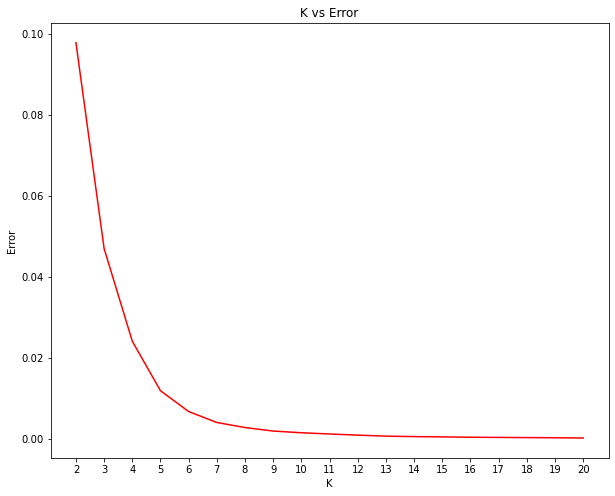

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [30]:
! pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

     |████████████████████████████████| 271 kB 14.7 MB/s eta 0:00:01


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


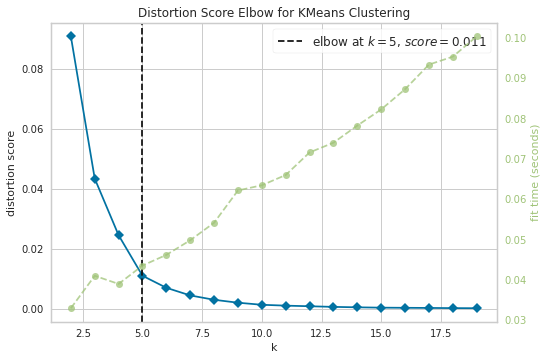

In [31]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In [32]:
kclusters = 5

toronto_grouped_clustering = cs.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 3, 1, 0, 0, 1, 3, 0, 0], dtype=int32)

In [33]:
# create a new dataframe that includes the cluster 
toronto_merged = cs.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

In [34]:
toronto_merged.head()

Neighbourhood  Coffee Shop  \
0                                        Agincourt     0.044444   
1                           Alderwood, Long Branch     0.103448   
2  Bathurst Manor, Wilson Heights, Downsview North     0.064516   
3                                  Bayview Village     0.000000   
4                Bedford Park, Lawrence Manor East     0.081081   

   Cluster Labels  
0               3  
1               0  
2               3  
3               1  
4               0

In [35]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_venues.set_index("Neighbourhood"), on="Neighbourhood")

print(toronto_merged.shape)
toronto_merged.head()

(5132, 9)


Neighbourhood  Coffee Shop  Cluster Labels  Neighbourhood Latitude  \
0     Agincourt     0.044444               3                43.79452   
0     Agincourt     0.044444               3                43.79452   
0     Agincourt     0.044444               3                43.79452   
0     Agincourt     0.044444               3                43.79452   
0     Agincourt     0.044444               3                43.79452   

   Neighbourhood Longitude                                    Venue  \
0                -79.26708                Bestco Food Market 鴻華超級市場   
0                -79.26708                   Wonton Chai Noodle 雲吞仔   
0                -79.26708         Yummy Cantonese Restaurant 老西関腸粉   
0                -79.26708              Panagio's Breakfast & Lunch   
0                -79.26708  Jesse Jr. (Filipino Foods & Restaurant)   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.796514       -79.270790           Supermarket  
0       43.787722       -79.269552          Noodle House  
0       43.787568       -79.269585  Cantonese Restaurant  
0       43.792370       -79.260203        Breakfast Spot  
0       43.787565       -79.268810            Restaurant

In [36]:
# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged.head()

(5132, 9)


Neighbourhood  Coffee Shop  Cluster Labels  \
31      Garden District, Ryerson         0.09               0   
81  The Danforth West, Riverdale         0.08               0   
81  The Danforth West, Riverdale         0.08               0   
81  The Danforth West, Riverdale         0.08               0   
81  The Danforth West, Riverdale         0.08               0   

    Neighbourhood Latitude  Neighbourhood Longitude                    Venue  \
31                43.65739                -79.37804            Dineen Coffee   
81                43.68375                -79.35512     Moksha Yoga Danforth   
81                43.68375                -79.35512         Don Valley Trail   
81                43.68375                -79.35512  Messini Authentic Gyros   
81                43.68375                -79.35512  The Danforth Music Hall   

    Venue Latitude  Venue Longitude    Venue Category  
31       43.650497       -79.378765              Café  
81       43.677622       -79.352116       Yoga Studio  
81       43.676331       -79.353923             Trail  
81       43.677704       -79.350480  Greek Restaurant  
81       43.676338       -79.357071      Concert Hall

In [39]:
# Finding all the coffee shops
toronto_merged['Venue Category'].value_counts()['Coffee Shop']

388

In [40]:
# Visualizing the clusters

# create map
map_clusters = folium.Map(location=[t_lat, t_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighbourhood Latitude'], toronto_merged['Neighbourhood Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [41]:
# cluster labels per neighbourhood
cs["Cluster Labels"] = kmeans.labels_
cs.head()

Neighbourhood  Coffee Shop  \
0                                        Agincourt     0.044444   
1                           Alderwood, Long Branch     0.103448   
2  Bathurst Manor, Wilson Heights, Downsview North     0.064516   
3                                  Bayview Village     0.000000   
4                Bedford Park, Lawrence Manor East     0.081081   

   Cluster Labels  
0               3  
1               0  
2               3  
3               1  
4               0

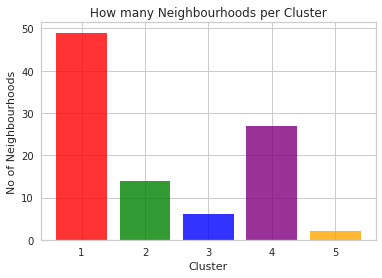

In [42]:
# ploting all number of neighbourhoods in each cluster
%matplotlib inline
from matplotlib import pyplot as plt

objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = cs['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'green','blue', 'purple', 'orange'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighbourhoods')
plt.xlabel('Cluster')
plt.title('How many Neighbourhoods per Cluster')

plt.show()

In [43]:
# How many neighborhoods in each cluster
cs['Cluster Labels'].value_counts()

0    49
3    27
1    14
2     6
4     2
Name: Cluster Labels, dtype: int64

In [44]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighbourhood']]
df_new.head()
print(df_new.shape)

(103, 2)


In [45]:
# Cluster 1- Red 
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighbourhood')
print(df_cluster1.shape)
print(df_cluster1['Coffee Shop'].mean())
df_cluster1.head()

(3449, 10)
0.08843142939982604


Borough     Neighbourhood  Coffee Shop  Cluster Labels  \
0  North York  Victoria Village     0.090909               0   
1  North York  Victoria Village     0.090909               0   
2  North York  Victoria Village     0.090909               0   
3  North York  Victoria Village     0.090909               0   
4  North York  Victoria Village     0.090909               0   

   Neighbourhood Latitude  Neighbourhood Longitude                   Venue  \
0                43.73057                -79.31306        Armenian Kitchen   
1                43.73057                -79.31306                 Jatujak   
2                43.73057                -79.31306  Victoria Village Arena   
3                43.73057                -79.31306             Tim Hortons   
4                43.73057                -79.31306               Portugril   

   Venue Latitude  Venue Longitude             Venue Category  
0       43.731071       -79.305390  Middle Eastern Restaurant  
1       43.736208       -79.307668            Thai Restaurant  
2       43.723481       -79.315635               Hockey Arena  
3       43.725517       -79.313103                Coffee Shop  
4       43.725819       -79.312785      Portuguese Restaurant

In [50]:
# Cluster 2 -Green 
cluster2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighbourhood')
print(df_cluster2.shape)
print(df_cluster2['Coffee Shop'].mean())
df_cluster2.head()

(272, 10)
0.007352941176470588


Borough Neighbourhood  Coffee Shop  Cluster Labels  \
0  North York     Parkwoods          0.0               1   
1  North York     Parkwoods          0.0               1   
2  North York     Parkwoods          0.0               1   
3  North York     Parkwoods          0.0               1   
4  North York     Parkwoods          0.0               1   

   Neighbourhood Latitude  Neighbourhood Longitude  \
0                43.75245                -79.32991   
1                43.75245                -79.32991   
2                43.75245                -79.32991   
3                43.75245                -79.32991   
4                43.75245                -79.32991   

                        Venue  Venue Latitude  Venue Longitude  \
0         Towns On The Ravine       43.754754       -79.332552   
1         Spicy Chicken House       43.760639       -79.325671   
2            Family Food Fair       43.760422       -79.325012   
3      Parkwoods Coin Laundry       43.760386       -79.324894   
4  Parkway Valley Tennis Club       43.754481       -79.318285   

       Venue Category  
0               Hotel  
1  Chinese Restaurant  
2                 ATM  
3     Laundry Service  
4        Tennis Court

In [51]:
# Cluster 3 - Blue 
cluster3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighbourhood')
print(df_cluster3.shape)
print(df_cluster3['Coffee Shop'].mean())
df_cluster3.head()

(212, 10)
0.14150943396226412


Borough              Neighbourhood  Coffee Shop  Cluster Labels  \
0  Downtown Toronto  Regent Park, Harbourfront         0.15               2   
1  Downtown Toronto  Regent Park, Harbourfront         0.15               2   
2  Downtown Toronto  Regent Park, Harbourfront         0.15               2   
3  Downtown Toronto  Regent Park, Harbourfront         0.15               2   
4  Downtown Toronto  Regent Park, Harbourfront         0.15               2   

   Neighbourhood Latitude  Neighbourhood Longitude        Venue  \
0                43.65512                -79.36264  Tim Hortons   
1                43.65512                -79.36264  Tim Hortons   
2                43.65512                -79.36264      Wendy’s   
3                43.65512                -79.36264    Sukhothai   
4                43.65512                -79.36264  Regent Park   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.659973       -79.365951           Coffee Shop  
1       43.659935       -79.361306            Restaurant  
2       43.660403       -79.360629  Fast Food Restaurant  
3       43.653701       -79.354447       Thai Restaurant  
4       43.660383       -79.361810                  Park

In [52]:
# Cluster 4 - Purple 
cluster4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighbourhood')
print(df_cluster4.shape)
print(df_cluster4['Coffee Shop'].mean())
df_cluster4.head()

(1483, 10)
0.04787592717464599


Borough                     Neighbourhood  Coffee Shop  Cluster Labels  \
0  North York  Lawrence Manor, Lawrence Heights     0.041667               3   
1  North York  Lawrence Manor, Lawrence Heights     0.041667               3   
2  North York  Lawrence Manor, Lawrence Heights     0.041667               3   
3  North York  Lawrence Manor, Lawrence Heights     0.041667               3   
4  North York  Lawrence Manor, Lawrence Heights     0.041667               3   

   Neighbourhood Latitude  Neighbourhood Longitude           Venue  \
0                43.72327                -79.45042        Fortinos   
1                43.72327                -79.45042  Shoeless Joe's   
2                43.72327                -79.45042          Subway   
3                43.72327                -79.45042    Petro-Canada   
4                43.72327                -79.45042             KFC   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.716656       -79.447257         Grocery Store  
1       43.718625       -79.455993            Restaurant  
2       43.716469       -79.454898        Sandwich Place  
3       43.715264       -79.446830           Gas Station  
4       43.716600       -79.447000  Fast Food Restaurant

In [53]:
# Cluster 5 - Orange
cluster5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]
df_cluster5 = pd.merge(df_new, cluster5, on='Neighbourhood')
print(df_cluster5.shape)
print(df_cluster5['Coffee Shop'].mean())
df_cluster5.head()

(16, 10)
0.25


Borough                             Neighbourhood  Coffee Shop  \
0  North York  North Park, Maple Leaf Park, Upwood Park         0.25   
1  North York  North Park, Maple Leaf Park, Upwood Park         0.25   
2  North York  North Park, Maple Leaf Park, Upwood Park         0.25   
3  North York  North Park, Maple Leaf Park, Upwood Park         0.25   
4  North York  North Park, Maple Leaf Park, Upwood Park         0.25   

   Cluster Labels  Neighbourhood Latitude  Neighbourhood Longitude  \
0               4                43.71381                -79.48874   
1               4                43.71381                -79.48874   
2               4                43.71381                -79.48874   
3               4                43.71381                -79.48874   
4               4                43.71381                -79.48874   

                                          Venue  Venue Latitude  \
0                     Lucky Dragon Chinese Food       43.719463   
1  Amesbury Sports Complex Arena & Outdoor Pool       43.705935   
2                                   Coffee Time       43.705864   
3                                    North Park       43.720478   
4                           Cataldi supermarket       43.715387   

   Venue Longitude      Venue Category  
0       -79.480755  Chinese Restaurant  
1       -79.486880  Athletics & Sports  
2       -79.488573         Coffee Shop  
3       -79.485729                Park  
4       -79.480004   Convenience Store

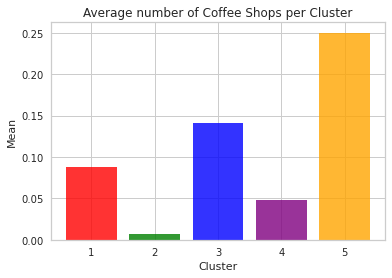

In [54]:
# ploting the number of coffee shops per cluster
clusters_mean = [df_cluster1['Coffee Shop'].mean(),df_cluster2['Coffee Shop'].mean(),df_cluster3['Coffee Shop'].mean(),
                 df_cluster4['Coffee Shop'].mean(),df_cluster5['Coffee Shop'].mean()]
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'green','blue', 'purple', 'orange'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Coffee Shops per Cluster')

plt.show()